# Setup

## Torch

In [1]:
import torch

In [2]:
torch.multiprocessing.get_sharing_strategy()

'file_descriptor'

In [3]:
torch.multiprocessing.get_start_method()

'fork'

In [4]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [5]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"device: {device}")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

device: cpu


## Imports

In [7]:
import re
import random
import os
import warnings
import LibMTL as mtl
import pandas as pd
import torch
import numpy as np
import xgboost as xgb
import emoji

from tqdm import trange
from torch import nn
from pathlib import Path

from sklearn import svm
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors
from LibMTL._record import _PerformanceMeter
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModel, AutoConfig, AutoTokenizer, XLNetTokenizerFast, DistilBertTokenizerFast
import datasets as ds
import seaborn as sns
import matplotlib.pyplot as plt

from torch.profiler import profile, record_function, ProfilerActivity

/cluster/home/stefandt/anaconda3/envs/ppconda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
mtl.utils.set_device(device.type)
os.environ['TOKENIZERS_PARALLELISM'] = "false"

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Config, Hyperparams

In [9]:
# DataFrame
generate_dataframe = True # If False, previously generated dataframe is loaded instead
mbti_frac = 0.10
bigfive_c_frac = 1.00
bigfive_s_frac = 1.00

# Exploratory Data Analysis
generate_eda = False # If False, EDA is skipped

# Reduce
generate_reduced = False
use_full = False

# Preprocessing
generate_features = False # If True
generate_partially_cleaned = False
generate_cleaned = False # If False, previously preprocessed dataframe is loaded instead
generate_embeddings = False # If False, previously generated Embeddings are loaded instead
generate_aggregated = False
generate_glove = False
generate_filled = True
model_name='distilbert'
model_path='distilbert-base-uncased' #   cardiffnlp/twitter-roberta-base    xlnet/xlnet-base-cased

# DataLoaders
num_workers = 2
pin_memory = True
batch_size = 64

# Split
generate_split = True
train_size = 0.8
test_size = 0.1

# Tokenizer
do_lower_case=True #default true distil
padding_side = 'right' # default right distil
truncation_side = 'right' # default right distil
max_length= 128
padding='max_length'
truncation=True

# Model
model_path='distilbert-base-uncased'
# cardiffnlp/twitter-roberta-base
# transformer-MD
# XLNet-Caps

# Shared
hidden_size=1028
save_path=None

# Training
epochs = 2

# MTL
weighting = 'GradNorm' # Aligned_MTL, RLW 
architecture = 'HPS' # MMoE, DSelect_k
optim_param = {'optim': 'adam', 'lr': 1e-3, 'weight_decay': 1e-4}
scheduler_param = None #{'scheduler': 'step', 'step_size': 1} # TODO: should change
kwargs = {'weight_args': {'alpha': 1.5}, 'arch_args': {}} # alpha: The strength of the restoring force which pulls tasks back to a common training rate.

## Paths

In [10]:
path_data_dir = Path('/cluster/work/jacobaal/pers-pred/data') / Path('raw')

# DataFrames
path_essays = path_data_dir / Path('essays') / Path('essays.csv')
path_kaggle_mbti = path_data_dir / Path('kaggle-mbti') / Path('mbti_1.csv')
path_mypers = path_data_dir / Path('mypers') / Path('mypersonality_final.csv')
path_pandora_comments = path_data_dir / Path('pandora') / Path('all_comments_since_2015.csv')
path_pandora_authors = path_data_dir / Path('pandora') / Path('author_profiles.csv')
path_tw_mbti = path_data_dir / Path('tw-mbti') / Path('twitter_MBTI.csv')

path_merged = path_data_dir / 'raw' / Path('merged.csv')
path_reduced = path_data_dir / Path('reduced.csv')

# GloVe
path_glove = Path('glove')
path_glove_params = path_glove / Path('glove.twitter.27B.50d.txt')
path_glove_w2v_params = path_glove / Path('glove.w2v.twitter.27B.50d.txt')

# Preprocessing
path_preprocessed_dir = path_data_dir / Path('full') if use_full else  path_data_dir / Path('reduced')

path_features = path_preprocessed_dir / Path('features.csv')
path_cleaned = path_preprocessed_dir / Path('cleaned.csv')
path_cleaned_text = path_preprocessed_dir / Path('cleaned_text.csv')
path_partially_cleaned = path_preprocessed_dir / Path('partially_cleaned.csv')
path_partially_cleaned_text = path_preprocessed_dir / Path('partially_cleaned_text.csv')
path_embeddings = path_preprocessed_dir / Path(model_name) / Path(f'{model_name}-test.csv') 
path_aggregated = path_preprocessed_dir / Path('aggregated.csv')
path_filled = path_preprocessed_dir / Path('filled.csv')

# Split
path_split_dir = path_data_dir / Path('split')

path_mbti = path_split_dir / Path('mbti.csv')
path_bigfive_c = path_split_dir / Path('bigfive_c.csv')
path_bigfive_s = path_split_dir / Path('bigfive_s.csv')

# Training
path_chkp = Path('checkpoints')

## Definitions

In [11]:
mbti_columns = ['mbtiEXT',	'mbtiSEN',	'mbtiTHI',	'mbtiJUD']
bigfive_c_columns = ['cEXT',	'cNEU',	'cAGR',	'cCON',	'cOPN']
bigfive_s_columns = ['sEXT',	'sNEU',	'sAGR',	'sCON',	'sOPN']
bigfive_columns = bigfive_c_columns + bigfive_s_columns

label_columns = mbti_columns + bigfive_columns
common_columns = ['AUTHOR', 'TEXT', 'SOURCE']

all_columns = common_columns + label_columns

binary_map = {
  "y": 1,
  "n": 0
}

kaggle_mbti_map = {
  'E': 1,
  'I': 0,
  'S': 1,
  'N': 0,
  'T': 1,
  'F': 0,
  'J': 1,
  'P': 0
}

tw_mbti_map = {
  'e': 1,
  'i': 0,
  's': 1,
  'n': 0,
  't': 1,
  'f': 0,
  'j': 1,
  'p': 0
}

## Models

In [12]:
if generate_glove:
  glove2word2vec(path_glove_params, path_glove_w2v_params)
  glove = KeyedVectors.load_word2vec_format(path_glove_w2v_params, binary=False)

In [13]:
tokenizer_args = {
  'pretrained_model_name_or_path': model_path,
  'do_lower_case': do_lower_case,
  'padding_side': padding_side,
  'truncation_side': truncation_side
}

if 'distilbert' in model_path: tokenizer = DistilBertTokenizerFast.from_pretrained(**tokenizer_args)
elif 'xlnet' in model_path: tokenizer = XLNetTokenizerFast.from_pretrained(**tokenizer_args)
else: tokenizer = AutoTokenizer.from_pretrained(**tokenizer_args)

/cluster/home/stefandt/anaconda3/envs/ppconda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
if generate_embeddings:
  model = AutoModel.from_pretrained(model_path)
  model.to(device)

# DataFrames

## Essays

In [42]:
if generate_dataframe:
  essays = pd.read_csv(path_essays, encoding='ISO-8859-1')
  for col in bigfive_c_columns: essays[col] = essays[col].map(binary_map)
  essays = essays.rename({
    '#AUTHID': 'AUTHOR',
  },
  axis='columns')

In [49]:
essays['AUTHOR']

0       1997_504851.txt
1       1997_605191.txt
2       1997_687252.txt
3       1997_568848.txt
4       1997_688160.txt
             ...       
2462       2004_493.txt
2463       2004_494.txt
2464       2004_497.txt
2465       2004_498.txt
2466       2004_499.txt
Name: AUTHOR, Length: 2467, dtype: object

## Kaggle MBTI

In [44]:
if generate_dataframe:
  kaggle_mbti = pd.read_csv(path_kaggle_mbti)

  kaggle_mbti['mbtiEXT'] = kaggle_mbti['type'].str[0]
  kaggle_mbti['mbtiSEN'] = kaggle_mbti['type'].str[1]
  kaggle_mbti['mbtiTHI'] = kaggle_mbti['type'].str[2]
  kaggle_mbti['mbtiJUD'] = kaggle_mbti['type'].str[3]
  for col in mbti_columns: kaggle_mbti[col] = kaggle_mbti[col].map(kaggle_mbti_map)
  kaggle_mbti = kaggle_mbti.drop('type', axis='columns')
  kaggle_mbti['posts'] = kaggle_mbti['posts'].str.split('\|\|\|')
  kaggle_mbti = kaggle_mbti.explode('posts').reset_index()
  kaggle_mbti = kaggle_mbti.rename({
    'posts': 'TEXT',
    'index': 'AUTHOR'
  }, axis='columns')

In [51]:
kaggle_mbti

,AUTHOR,TEXT,mbtiEXT,mbtiSEN,mbtiTHI,mbtiJUD
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw,0,0,0,1
1,0,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,0,0,0,1
2,0,enfp and intj moments https://www.youtube.com...,0,0,0,1
3,0,What has been the most life-changing experienc...,0,0,0,1
4,0,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,0,0,0,1
...,...,...,...,...,...,...
422840,8674,I was going to close my facebook a few months ...,0,0,0,0
422841,8674,30 Seconds to Mars - All of my collections. It...,0,0,0,0
422842,8674,"I have seen it, and i agree. I did actually th...",0,0,0,0
422843,8674,Ok so i have just watched Underworld 4 (Awaken...,0,0,0,0


## MyPers

In [56]:
if generate_dataframe:
  mypers = pd.read_csv(path_mypers, encoding='ISO-8859-1', usecols=['#AUTHID',	'STATUS',	'sEXT',	'sNEU',	'sAGR',	'sCON',	'sOPN',	'cEXT',	'cNEU',	'cAGR',	'cCON',	'cOPN'])
  mypers = mypers.rename({
    '#AUTHID': 'AUTHOR',
    'STATUS': 'TEXT',
  }, axis='columns')
  for col in bigfive_c_columns:
      mypers[col] = mypers[col].map(binary_map)
  
  # Normalize to percentiles
  author_scores = mypers.groupby('AUTHOR')[bigfive_s_columns].mean().reset_index()
  author_percentiles = author_scores[bigfive_s_columns].rank(pct=True) * 100
  author_percentiles['AUTHOR'] = author_scores['AUTHOR']
  mypers = mypers.drop(bigfive_s_columns, axis='columns').merge(author_percentiles, on='AUTHOR')

In [57]:
mypers

,AUTHOR,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY,sEXT,sNEU,sAGR,sCON,sOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,0,1,0,0,1,06/19/09 03:21 PM,180.0,14861.60,93.29,0.03,15661.0,0.49,0.10,24.6,69.0,24.8,37.4,66.4
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,0,1,0,0,1,07/02/09 08:41 AM,180.0,14861.60,93.29,0.03,15661.0,0.49,0.10,24.6,69.0,24.8,37.4,66.4
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,0,1,0,0,1,06/15/09 01:15 PM,180.0,14861.60,93.29,0.03,15661.0,0.49,0.10,24.6,69.0,24.8,37.4,66.4
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,0,1,0,0,1,06/22/09 04:48 AM,180.0,14861.60,93.29,0.03,15661.0,0.49,0.10,24.6,69.0,24.8,37.4,66.4
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,0,1,0,0,1,07/20/09 02:31 AM,180.0,14861.60,93.29,0.03,15661.0,0.49,0.10,24.6,69.0,24.8,37.4,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,deb899e426c1a5c66c24eeb0d7df6257,little things give you away.,0,0,1,0,1,01/28/10 11:48 AM,36.0,185.71,31.21,0.40,377.0,0.32,0.63,10.8,29.8,75.2,17.2,80.4
9913,ea28a927cb6663480ea33ca917c3c8ba,is wishing it was Saturday.,1,1,1,1,1,02/02/10 08:08 PM,83.0,2935.76,88.40,0.08,3120.0,0.47,0.26,78.2,82.6,59.6,69.8,73.6
9914,ea28a927cb6663480ea33ca917c3c8ba,is studying hard for the G.R.E.,1,1,1,1,1,02/09/10 08:04 PM,83.0,2935.76,88.40,0.08,3120.0,0.47,0.26,78.2,82.6,59.6,69.8,73.6
9915,5532642937eb3497a43e15dbb23a9d2d,snipers get more head,0,1,0,0,1,02/10/10 02:01 AM,154.0,11424.50,98.25,0.02,11510.0,0.49,0.05,1.2,96.8,34.8,44.0,36.6


## Twitter MBTI

In [59]:
if generate_dataframe:
  tw_mbti = pd.read_csv(path_tw_mbti)
  tw_mbti['mbtiEXT'] = tw_mbti['label'].str[0]
  tw_mbti['mbtiSEN'] = tw_mbti['label'].str[1]
  tw_mbti['mbtiTHI'] = tw_mbti['label'].str[2]
  tw_mbti['mbtiJUD'] = tw_mbti['label'].str[3]

  for col in mbti_columns: tw_mbti[col] = tw_mbti[col].map(tw_mbti_map)
  tw_mbti = tw_mbti.drop('label', axis='columns')
  tw_mbti = tw_mbti.rename({
    'Unnamed: 0': 'AUTHOR',
    'text': 'TEXT'
    }, axis='columns')
  tw_mbti['TEXT'] = tw_mbti['TEXT'].str.split('\|\|\|')
  tw_mbti = tw_mbti.explode('TEXT').reset_index(drop=True)

In [60]:
tw_mbti['AUTHOR'].nunique()

7811

## PANDORA

In [12]:
if generate_dataframe:
  pandora_authors = pd.read_csv(path_pandora_authors) # usecols=['author', 'introverted', 'intuitive', 'thinking', 'perceiving', 
                                    # 'agreeableness', 'openness', 'conscientiousness', 'extraversion','neuroticism']
  pandora_comments = pd.read_csv(path_pandora_comments) # usecols=['author', 'body']
  pandora_authors = pandora_authors.rename({
    'author': 'AUTHOR', 
    'introverted': 'mbtiEXT', # Flip
    'intuitive': 'mbtiSEN', # Flip
    'thinking': 'mbtiTHI', 
    'perceiving': 'mbtiJUD', # Flip 
    'agreeableness': 'sAGR', 
    'openness': 'sOPN', 
    'conscientiousness': 'sCON', 
    'extraversion': 'sEXT',
    'neuroticism': 'sNEU'
  },
  axis ='columns')
  pandora_authors[['mbtiEXT', 'mbtiSEN', 'mbtiJUD']] = 1 - pandora_authors[['mbtiEXT', 'mbtiSEN', 'mbtiJUD']]
  pandora_comments = pandora_comments.rename({
    'author': 'AUTHOR',
    'body': 'TEXT'
  },
  axis='columns')
  pandora = pd.merge(pandora_authors, pandora_comments, on='AUTHOR')

In [13]:
pandora

,AUTHOR,mbti,mbtiEXT,mbtiSEN,mbtiTHI,mbtiJUD,gender,age,enneagram,country,...,parent_id,score,controversiality,gilded,id,subreddit,ups,word_count,word_count_quoteless,lang
0,-Afrodisiac-,intp,0.0,0.0,1.0,0.0,m,19.0,NaN,NaN,...,t1_d7z8pcs,2.0,0.0,0.0,d7zeyrp,Blackfellas,2.0,5.0,5.0,en
1,-Afrodisiac-,intp,0.0,0.0,1.0,0.0,m,19.0,NaN,NaN,...,t1_d6nhj90,1.0,0.0,0.0,d6o4wad,INTP,1.0,8.0,8.0,en
2,-Afrodisiac-,intp,0.0,0.0,1.0,0.0,m,19.0,NaN,NaN,...,t1_d4ixhon,5.0,0.0,0.0,d4izjvx,mbti,5.0,25.0,25.0,en
3,-Afrodisiac-,intp,0.0,0.0,1.0,0.0,m,19.0,NaN,NaN,...,t3_4m9avt,1.0,0.0,0.0,d3u3s53,INTP,1.0,107.0,107.0,en
4,-Afrodisiac-,intp,0.0,0.0,1.0,0.0,m,19.0,NaN,NaN,...,t1_d6hmzwk,1.0,0.0,0.0,d6hnku2,entp,1.0,56.0,56.0,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17640056,yrelav_dnomyar,intj,0.0,0.0,1.0,1.0,f,24.0,NaN,NaN,...,t3_4ycvdt,1.0,0.0,0.0,d6n7gwr,intj,1.0,915.0,896.0,en
17640057,yrelav_dnomyar,intj,0.0,0.0,1.0,1.0,f,24.0,NaN,NaN,...,t1_d6tjjmy,2.0,0.0,0.0,d6tr1ka,intj,2.0,62.0,61.0,en
17640058,yrelav_dnomyar,intj,0.0,0.0,1.0,1.0,f,24.0,NaN,NaN,...,t1_dsdluzd,4.0,0.0,0.0,dsdqfai,GH5,NaN,1.0,1.0,NaN
17640059,yrelav_dnomyar,intj,0.0,0.0,1.0,1.0,f,24.0,NaN,NaN,...,t1_dw5bdck,2.0,0.0,0.0,dwfh3ss,weddingvideography,NaN,27.0,27.0,en


In [15]:
pandora['AUTHOR'].nunique()

10295

## Merged

In [20]:
if generate_dataframe:
  for dataframe in [essays, kaggle_mbti, mypers, pandora, tw_mbti]:
    dataframe = dataframe.reindex(columns=all_columns, fill_value=None)

NameError: name 'essays' is not defined

In [ ]:
if generate_dataframe:
  essays['SOURCE'] = 'essays'
  kaggle_mbti['SOURCE'] = 'kaggle_mbti'
  mypers['SOURCE'] = 'mypers'
  pandora['SOURCE'] = 'pandora'
  tw_mbti['SOURCE'] = 'tw_mbti'

In [ ]:
if generate_dataframe:
  essays = essays.reindex(columns=all_columns, fill_value=None)
  kaggle_mbti = kaggle_mbti.reindex(columns=all_columns, fill_value=None)
  mypers = mypers.reindex(columns=all_columns, fill_value=None)
  pandora = pandora.reindex(columns=all_columns, fill_value=None)
  tw_mbti = tw_mbti.reindex(columns=all_columns, fill_value=None)
  datasets = [essays, kaggle_mbti, mypers, pandora, tw_mbti]
  for dataset in datasets:
    print(dataset.shape)

(2467, 17)
(422845, 17)
(9917, 17)
(17640061, 17)
(1093199, 17)


In [22]:
if generate_dataframe:
  data = pd.concat(datasets, 
                  axis=0, 
                  ignore_index=True,
                  copy=False)
  data['AUTHOR'] = data['AUTHOR'].apply(str)
  data['AUTHOR'] += data['SOURCE']
  data['AUTHOR'] = data['AUTHOR'].apply(hash)

  # Sirsapalli and Malla (2023) found that removing posts with fewer than 3 words substancially improved performance
  data = data.loc[data['TEXT'].str.split().str.len() > 2]
  path = '/cluster/work/jacobaal/pers-pred/data/raw/merged.csv'
  data.to_csv(
    path,
    index=False
  )
  data = data.reset_index()
else:
  path = '/cluster/work/jacobaal/pers-pred/data/raw/merged.csv'
  data = pd.read_csv(path)
data

,index,AUTHOR,TEXT,SOURCE,mbtiEXT,mbtiSEN,mbtiTHI,mbtiJUD,cEXT,cNEU,cAGR,cCON,cOPN,sEXT,sNEU,sAGR,sCON,sOPN,LENGTH
0,0,8396148113617426566,"Well, right now I just woke up from a mid-day ...",essays,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,3249
1,1,2470504050685251594,"Well, here we go with the stream of consciousn...",essays,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3316
2,2,-5596183263125549086,An open keyboard and buttons to push. The thin...,essays,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3938
3,3,-2286627974080081353,I can't believe it! It's really happening! M...,essays,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1815
4,4,-5970852408841551929,"Well, here I go with the good old stream of co...",essays,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,4812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634759,19168483,-6407393823822028694,i loved the whole mcyt/geoguesser fandom colli...,tw_mbti,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
5634760,19168484,-6407393823822028694,@paytonstyleslol ILL BE THINKING REAL HARD,tw_mbti,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
5634761,19168485,-6407393823822028694,i am at olive garden and my sister ordered the...,tw_mbti,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
5634762,19168486,-6407393823822028694,@paytonstyleslol you’re so right,tw_mbti,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32


# Exploratory Data Analysis

In [23]:
dataset  = data[['mbtiEXT', 'cOPN', 'sNEU']].rename({
    'mbtiEXT': 'MBTI', 
    'cOPN': 'Big Five Class', 
    'sNEU': 'Big Five Score'
})

In [31]:
dataset = dataset.rename({
    'mbtiEXT': 'MBTI', 
    'cOPN': 'Big Five Class', 
    'sNEU': 'Big Five Score'
}, axis=1)

In [32]:
dataset

,MBTI,Big Five Class,Big Five Score
0,NaN,1.0,NaN
1,NaN,0.0,NaN
2,NaN,1.0,NaN
3,NaN,0.0,NaN
4,NaN,1.0,NaN
...,...,...,...
5634759,0.0,NaN,NaN
5634760,0.0,NaN,NaN
5634761,0.0,NaN,NaN
5634762,0.0,NaN,NaN


In [ ]:
data.count()

index      5634764
AUTHOR     5634764
TEXT       5634764
SOURCE     5634764
mbtiEXT    3726592
mbtiSEN    3752659
mbtiTHI    3737490
mbtiJUD    3738969
cEXT         11857
cNEU         11857
cAGR         11857
cCON         11857
cOPN         11857
sEXT       2880657
sNEU       2874349
sAGR       2858416
sCON       2872929
sOPN       2822967
LENGTH     5634764
dtype: int64

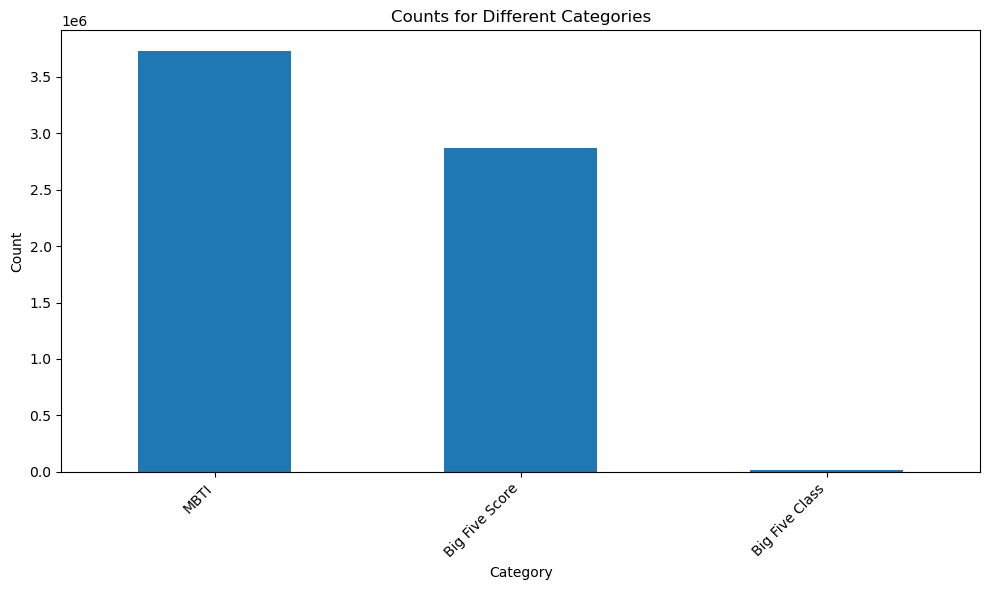

In [33]:
plt.figure(figsize=(10, 6))
dataset.count().sort_values(ascending=False).plot(kind='bar')
plt.title('Counts for Different Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
lengths = data['TEXT'].str.len().value_counts().sort_index()
lengths

TEXT
5         165
6          86
7         350
8         741
9        2078
         ... 
23687       2
30855       2
44357       1
61138       1
78425       1
Name: count, Length: 7323, dtype: int64

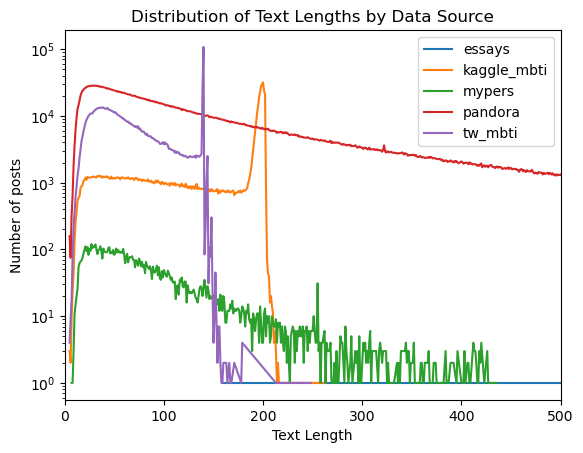

In [31]:
data['LENGTH'] = data['TEXT'].str.len()
sources = data['SOURCE'].unique()
for source in sources:
    subset = data[data['SOURCE'] == source]
    subset_counts = subset['LENGTH'].value_counts().sort_index()
    plt.plot(subset_counts.index, subset_counts.values, label=source)

plt.xlim(0, 500)  
plt.yscale('log')
plt.xlabel('Text Length')
plt.ylabel('Number of posts')
plt.title('Distribution of Text Lengths by Data Source')
plt.legend()
plt.show()

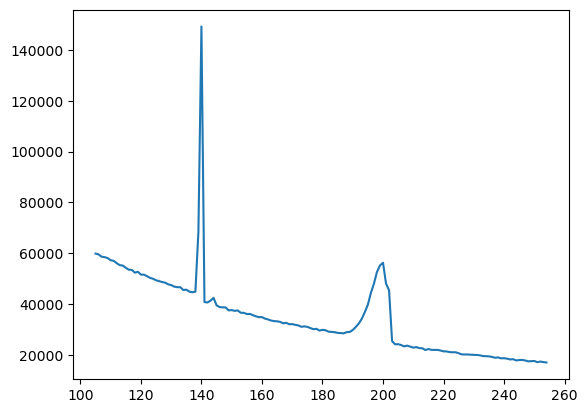

In [ ]:
plt.xlim(100, 250) 
plt.xlabel('Text Length')
plt.ylabel('Number of posts')
plt.title('Distribution of Text Lengths by Data Source')
plt.legend()
plt.show()

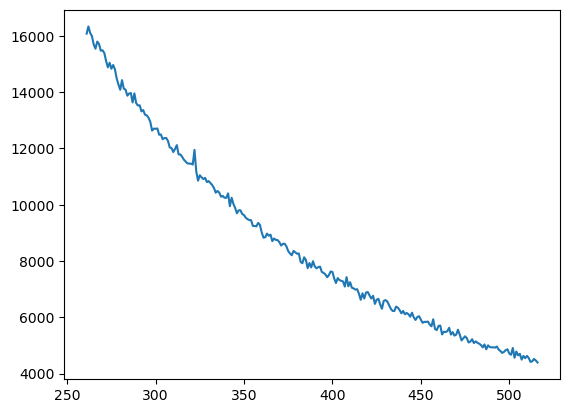

In [ ]:
fig, ax = plt.subplots()
ax = ax.plot(lengths.index[256:512], lengths.values[256:512])
plt.show()

In [ ]:
data140 = data.loc[data['TEXT'].str.len() == 140]

In [33]:
def tokenize_func(text):
  return tokenizer(text, padding=False, max_length=None, truncation=False, return_attention_mask=False)['input_ids']

In [34]:
tokenized140 = data140['TEXT'].map(tokenize_func)

In [35]:
lengths140 = tokenized140.map(len).value_counts().sort_index()

[]

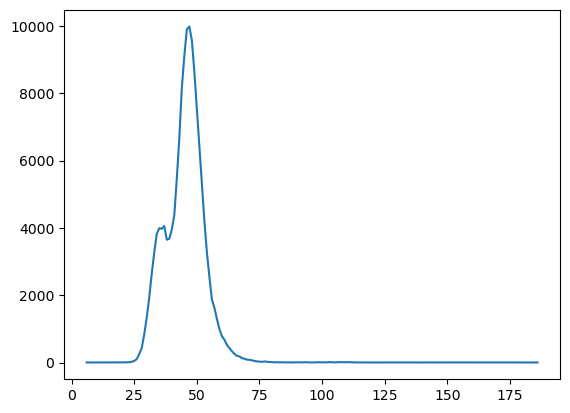

In [36]:
fig, ax = plt.subplots()
ax = ax.plot(lengths140.index, lengths140.values)
plt.plot()

In [37]:
lenghts200 = data.loc[data['TEXT'].str.len() == 9999]['TEXT'].map(tokenize_func).map(len).value_counts().sort_index()

Token indices sequence length is longer than the specified maximum sequence length for this model (4002 > 512). Running this sequence through the model will result in indexing errors


In [38]:
print(lenghts200)

TEXT
6       1
2002    4
2426    1
2502    2
3034    1
4002    3
6002    1
Name: count, dtype: int64


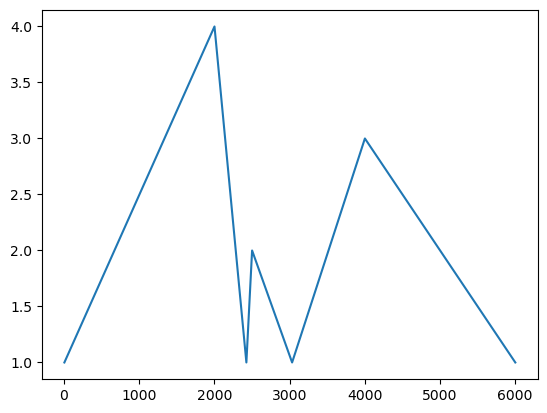

In [39]:
fig, ax = plt.subplots()
ax = ax.plot(lenghts200.index, lenghts200.values)
plt.show()

## Data Reduction

In [40]:
if generate_reduced:
  mbti_mask = data[(data['SOURCE'] == 'pandora') & 
                 (data[mbti_columns].notna().all(axis=1)) & 
                 (data[bigfive_columns].isnull().all(axis=1))]

  authors_to_remove = mbti_mask['AUTHOR'].unique()
  num_rows_to_remove = int(len(authors_to_remove) * (1 - mbti_frac))
  selected_authors = np.random.choice(authors_to_remove, size=num_rows_to_remove, replace=False)
  data = data[~data['AUTHOR'].isin(selected_authors)]
  print(len(data))
  print(len(data[common_columns + mbti_columns].dropna(axis=0)))
  print(len(data[common_columns + bigfive_c_columns].dropna(axis=0)))
  print(len(data[common_columns + bigfive_s_columns].dropna(axis=0)))
  data.to_csv(
    path_merged,
    index=False
  )
  data = data.reset_index()
else:
  data = pd.read_csv(path_merged)
data = data.sort_values('AUTHOR')

5634764
3713701
11857
2788583


In [ ]:
data['LENGTH'] = data['TEXT'].str.len()
sources = data['SOURCE'].unique()
for source in sources:
    subset = data[data['SOURCE'] == source]
    subset_counts = subset['LENGTH'].value_counts().sort_index()
    plt.plot(subset_counts.index, subset_counts.values, label=source)

plt.xlim(2000, 2500)  
plt.ylim(0, 300)
plt.xlabel('Text Length')
plt.ylabel('Number of posts')
plt.title('Distribution of Text Lengths by Data Source')
plt.legend()
plt.show()

# Preprocessing

## Statistical Feature Extraction

In [41]:
if generate_features:
    data['NUM_CHARS'] = data['TEXT'].str.len()
    data['NUM_UPPERCASED'] = data['TEXT'].str.count(r'[A-Z]')
    data['NUM_EMOJI'] = data['TEXT'].apply(emoji.emoji_count)
    data.to_csv(path_features, index=False)
else:
    data = pd.read_csv(path_features)

## Data Cleaning

In [42]:
regex_duplicate = re.compile(r'(.)\1{2,}')  # Matches characters repeated more than twice
regex_word_nonword = re.compile(r'(\w)([^\w\s])')  # Matches a word character followed by a non-word character
regex_nonword_word = re.compile(r'([^\w\s])(\w)')  # Matches a non-word character followed by a word character
regex_nonword_space = re.compile(r'(\W)\s+(\W)')  # Matches a non-word character followed by spaces and another non-word character
regex_space_punctuation = re.compile(r'\s+([,.!?])')  # Matches spaces followed by punctuation marks
regex_hashtag = re.compile(r'#\w+')  # Matches hashtags
regex_url = re.compile(r'http\S+')  # Matches URLs
regex_mention = re.compile(r'@\w+')  # Matches mentions

def process_text(text):
    text = regex_duplicate.sub(r'\1\1\1', text) 
    text = regex_word_nonword.sub(r'\1 \2', text) 
    text = regex_nonword_word.sub(r'\1 \2', text)  
    text = regex_nonword_space.sub(r'\1\2', text) 
    text = regex_space_punctuation.sub(r'\1', text) 
    # text = regex_hashtag.sub('HASHTAG', text)
    text = regex_url.sub('URL', text) 
    text = regex_mention.sub('MENTION', text)  
    return text

In [43]:
if generate_partially_cleaned:
  data['TEXT'] = data['TEXT'].map(str)
  data['TEXT'] = data['TEXT'].apply(process_text)
  data.to_csv(path_cleaned, index=False)
  data['TEXT'].to_csv(path_partially_cleaned_text, index=False)
else: 
  data = pd.read_csv(path_partially_cleaned)

In [44]:
if generate_cleaned:
  data['TEXT'] = data['TEXT'].apply(emoji.demojize)
  data.to_csv(path_cleaned, index=False)
  data['TEXT'].to_csv(path_cleaned_text, index=False)
else:
  data = pd.read_csv(path_cleaned)

In [45]:
data.head(5)

,level_0,index,AUTHOR,TEXT,SOURCE,mbtiEXT,mbtiSEN,mbtiTHI,mbtiJUD,cEXT,...,cOPN,sEXT,sNEU,sAGR,sCON,sOPN,LENGTH,NUM_CHARS,NUM_UPPERCASED,NUM_EMOJI
5584365,17706868,19112153,-9221022384933360074,This year i ' ve been watching classic movies ...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,127,127,18,0
5584383,17706886,19112172,-9221022384933360074,The amount of swearwords i yelled at living cr...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104,104,1,0
5584384,17706887,19112173,-9221022384933360074,Little break from homework URL :// t. co / qgN...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50,50,6,0
5584385,17706888,19112174,-9221022384933360074,a roasted snake URL :// t. co / xq3SNsOYtM,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,39,39,5,0
5584360,17706863,19112147,-9221022384933360074,@ Achijebieterfy Twoja stara,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27,27,2,0


In [46]:
data

,level_0,index,AUTHOR,TEXT,SOURCE,mbtiEXT,mbtiSEN,mbtiTHI,mbtiJUD,cEXT,...,cOPN,sEXT,sNEU,sAGR,sCON,sOPN,LENGTH,NUM_CHARS,NUM_UPPERCASED,NUM_EMOJI
5584365,17706868,19112153,-9221022384933360074,This year i ' ve been watching classic movies ...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,127,127,18,0
5584383,17706886,19112172,-9221022384933360074,The amount of swearwords i yelled at living cr...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104,104,1,0
5584384,17706887,19112173,-9221022384933360074,Little break from homework URL :// t. co / qgN...,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,50,50,6,0
5584385,17706888,19112174,-9221022384933360074,a roasted snake URL :// t. co / xq3SNsOYtM,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,39,39,5,0
5584360,17706863,19112147,-9221022384933360074,@ Achijebieterfy Twoja stara,tw_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27,27,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37663,37663,39855,9222919918896192253,"Poe. I don ' t mind Shakespeare, but I especia...",kaggle_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,91,91,5,0
37648,37648,39837,9222919918896192253,Why is it always so hot at band camp? The sun ...,kaggle_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,183,183,3,0
37664,37664,39856,9222919918896192253,Insurgent by Veronica Roth and City of Glass b...,kaggle_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63,63,7,0
37654,37654,39843,9222919918896192253,Why do my friends like to talk about feelings ...,kaggle_mbti,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,70,70,4,0


## Embeddings

Should be ran using `src/gen_emb.py` on SLURM

In [ ]:
embeddings = pd.read_csv

## Aggregation

In [ ]:
if generate_aggregated:
  data = data.groupby(by='AUTHOR', axis='columns').mean()
  data.to_csv(path_aggregated, index=False)
else:
  data = pd.read_csv(path_aggregated)
data

## FillNaN

# Seperate

In [ ]:
if not generate_split:
  mbti_df = data[['AUTHOR',	'TEXT',	'mbtiEXT',	'mbtiSEN',	'mbtiTHI',	'mbtiJUD']]
  bf_c_df = data[['AUTHOR',	'TEXT',	'cEXT',	'cNEU',	'cAGR',	'cCON',	'cOPN']]
  bf_s_df = data[['AUTHOR', 'TEXT', 'sEXT',	'sNEU',	'sAGR',	'sCON',	'sOPN']]
  mbti_df = mbti_df.dropna(axis=0).sample(frac=mbti_frac)
  bf_c_df = bf_c_df.dropna(axis=0).sample(frac=bigfive_c_frac)
  bf_s_df = bf_s_df.dropna(axis=0).sample(frac=bigfive_s_frac)
  mbti_df.to_csv(path_mbti)
  bf_c_df.to_csv(path_bigfive_c)
  bf_s_df.to_csv(path_bigfive_s)
else:
  mbti = pd.read_csv(path_mbti)
  bf_c_df = pd.read_csv(path_bigfive_c)
  bf_s_df = pd.read_csv(path_bigfive_s)

In [ ]:
mbti_df.head(3)

In [ ]:
bf_c_df.head(3)

In [ ]:
bf_s_df.head(3) # Scores need to be normalized

# Dataset, DataLoaders

In [ ]:
class PPDataset(Dataset):
  def __init__(self, data:pd.DataFrame, tokenizer):
    """
    task: 'mbti', 'bigfive_c', 'bigfive_s'
    """
    data = data.reset_index(drop=True)
    self.data_x = tokenizer(
      data["TEXT"].tolist(), 
      return_tensors='pt', 
      padding=padding,
      max_length=max_length, 
      truncation=truncation
      )

    data = data.drop(columns=['AUTHOR', 'TEXT'])
    self.data_y = torch.tensor(data=data.values, dtype=torch.float)

  def __len__(self):
    return self.data_y.shape[0]
  
  def __getitem__(self, index):
    x = {
      'input_ids': self.data_x['input_ids'][index],
      'attention_mask': self.data_x['attention_mask'][index]
    }
    y = self.data_y[index]
    return x, y

In [ ]:
mbti_ds = PPDataset(mbti_df, tokenizer)
bf_c_ds = PPDataset(bf_c_df, tokenizer)
bf_s_ds = PPDataset(bf_s_df, tokenizer)

In [ ]:
def split_dataset(dataset: Dataset, train_size: float, test_size: float):
  total_length = len(dataset)
  train_length = int(train_size * total_length)
  test_length = int(test_size * total_length)
  val_length = total_length - (train_length + test_length)
  return random_split(dataset, [train_length, test_length, val_length])

In [ ]:
train_mbti, test_mbti, val_mbti = split_dataset(mbti_ds, train_size, test_size)
train_bf_c, test_bf_c, val_bf_c = split_dataset(bf_c_ds, train_size, test_size)
train_bf_s, test_bf_s, val_bf_s = split_dataset(bf_s_ds, train_size, test_size)

In [ ]:
train_dl_args = {
  'batch_size': batch_size, 
  'num_workers': num_workers, 
  'shuffle': True, 
  'drop_last': True,
  'pin_memory': pin_memory
  }
val_test_dl_args = {
  'batch_size': batch_size, 
  'num_workers': num_workers, 
  'shuffle': False, 
  'drop_last': True,
  'pin_memory': pin_memory
  }

In [ ]:
train_dataloaders = {
    'mbti': DataLoader(train_mbti, **train_dl_args),
    'bigfive_c': DataLoader(train_bf_c, **train_dl_args),
    'bigfive_s': DataLoader(train_bf_s, **train_dl_args)
}
val_dataloaders = {
    'mbti': DataLoader(val_mbti, **val_test_dl_args),
    'bigfive_c': DataLoader(val_bf_c, **val_test_dl_args),
    'bigfive_s': DataLoader(val_bf_s, **val_test_dl_args)
}
test_dataloaders = {
    'mbti': DataLoader(test_mbti, **val_test_dl_args),
    'bigfive_c': DataLoader(test_bf_c, **val_test_dl_args),
    'bigfive_s': DataLoader(test_bf_s, **val_test_dl_args)
}

In [ ]:
dataloaders = [train_dataloaders, val_dataloaders, test_dataloaders]
for dataloader in dataloaders:
  for k in dataloader:
    dl_len = len(dataloader[k])
    print(k, dl_len)
    if dl_len == 0:
      raise ValueError("Dataloader", k, "is empty")

## Definitions

In [ ]:
# Should use Macro-F1 to balance

class BCEMetric(mtl.metrics.AbsMetric):
    r"""Calculate the Binary Cross-Entropy (BCE) loss.
    """
    def __init__(self):
        super(BCEMetric, self).__init__()
        self.criterion = nn.BCELoss()
        
    def update_fun(self, pred, gt):
        r"""
        Args:
            pred (torch.Tensor): The predicted tensor with shape (batch_size, num_classes).
            gt (torch.Tensor): The ground-truth tensor with shape (batch_size, num_classes).
        """
        loss = self.criterion(pred, gt)
        self.record.append(loss.item())
        self.bs.append(pred.size(0))
        
    def score_fun(self):
        r"""
        Returns:
            list: A list containing the average BCE loss across all iterations.
        """
        avg_loss = sum(self.record) / len(self.record)
        return [avg_loss]

class MAEMetric(mtl.metrics.AbsMetric):
    r"""Calculate the Mean Absolute Error (MAE).
    """
    def __init__(self):
        super(MAEMetric, self).__init__()
        
    def update_fun(self, pred, gt):
        r"""
        Args:
            pred (torch.Tensor): The predicted tensor with shape (batch_size, num_classes).
            gt (torch.Tensor): The ground-truth tensor with shape (batch_size, num_classes).
        """
        abs_err = torch.abs(pred - gt).mean()
        self.record.append(abs_err.item())
        self.bs.append(pred.size(0))
        
    def score_fun(self):
        r"""
        Returns:
            list: A list containing the average MAE across all iterations.
        """
        records = np.array(self.record)
        batch_size = np.array(self.bs)
        return [(records * batch_size).sum() / (sum(batch_size))]

In [ ]:
class Encoder(nn.Module):
  def __init__(self) -> None:
    super(Encoder, self).__init__()
    self.config = AutoConfig.from_pretrained(model_path)
    self.model = AutoModel.from_pretrained(model_path, config=self.config)
    self.dropout1 = nn.Dropout(0.1)
    self.hidden = nn.Linear(self.model.config.hidden_size, hidden_size)
    self.dropout2 = nn.Dropout(0.1)

  def forward(self, inputs):
    x = self.model(**inputs, output_hidden_states=True)
    x = self.dropout1(x.last_hidden_state)
    x = x[:, 0, :]  # Take the first token's embedding (CLS token)
    x = self.hidden(x)
    x = self.dropout2(x)
    return x

In [ ]:
class Classifier(nn.Module):
  def __init__(self, hidden_size, output_size) -> None:
    super(Classifier, self).__init__()
    self.linear = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    x = self.linear(x)
    x = torch.sigmoid(x)
    return x
  
class Regressor(nn.Module):
  def __init__(self, hidden_size, output_size) -> None:
    super(Regressor, self).__init__()
    self.linear = nn.Linear(hidden_size, output_size)
    self.activation = nn.ReLU()
  
  def forward(self, x):
    x = self.linear(x)
    x = self.activation(x)
    return x

In [ ]:
decoders = nn.ModuleDict({
  'mbti': Classifier(hidden_size, 4),
  'bigfive_c': Classifier(hidden_size, 5), 
  'bigfive_s': Regressor(hidden_size, 5)
  })

In [ ]:
class PPTrainer(mtl.Trainer):
  def __init__(self, task_dict, weighting, architecture, encoder_class, decoders, 
                 rep_grad, multi_input, optim_param, scheduler_param, 
                 save_path=None, load_path=None, device=torch.device('cuda:0'), **kwargs):
        nn.Module.__init__(self)
        
        self.device = device # added
        self.kwargs = kwargs
        self.task_dict = task_dict
        self.task_num = len(task_dict)
        self.task_name = list(task_dict.keys())
        self.rep_grad = rep_grad
        self.multi_input = multi_input
        self.scheduler_param = scheduler_param
        self.save_path = save_path
        self.load_path = load_path

        self._prepare_model(weighting, architecture, encoder_class, decoders)
        self._prepare_optimizer(optim_param, scheduler_param)
        
        self.meter = _PerformanceMeter(self.task_dict, self.multi_input)

  def _process_data(self, loader):
        try:
            data, label = next(loader[1])
        except:
            loader[1] = iter(loader[0])
            data, label = next(loader[1])
        try:
          data['input_ids'] = data['input_ids'].squeeze(1)
          data['attention_mask'] = data['attention_mask'].squeeze(1)
          data['input_ids'] = data['input_ids'].to(self.device, non_blocking=True)
          data['attention_mask'] = data['attention_mask'].to(self.device, non_blocking=True)
        except KeyError:
          data = data.to(self.device, non_blocking=True)
        if not self.multi_input:
            for task in self.task_name:
                label[task] = label[task].to(self.device, non_blocking=True)
        else:
            label = label.to(self.device, non_blocking=True)
        return data, label
  
  def train(self, train_dataloaders, test_dataloaders, epochs, 
              val_dataloaders=None, return_weight=False):
        r'''The training process of multi-task learning.

        Args:
            train_dataloaders (dict or torch.utils.data.DataLoader): The dataloaders used for training. \
                            If ``multi_input`` is ``True``, it is a dictionary of name-dataloader pairs. \
                            Otherwise, it is a single dataloader which returns data and a dictionary \
                            of name-label pairs in each iteration.

            test_dataloaders (dict or torch.utils.data.DataLoader): The dataloaders used for the validation or testing. \
                            The same structure with ``train_dataloaders``.
            epochs (int): The total training epochs.
            return_weight (bool): if ``True``, the loss weights will be returned.
        '''
        train_loader, train_batch = self._prepare_dataloaders(train_dataloaders)
        train_batch = max(train_batch) if self.multi_input else train_batch
        
        self.batch_weight = np.zeros([self.task_num, epochs, train_batch])
        self.model.train_loss_buffer = np.zeros([self.task_num, epochs])
        self.model.epochs = epochs
        for epoch in range(epochs):
            self.model.epoch = epoch
            self.model.train()
            self.meter.record_time('begin')
            with trange(train_batch, desc="Training", unit="batch") as pprange:
                for batch_index in pprange:
                    allocated = round(torch.cuda.memory_allocated(0)/1024**3,1)
                    cached = round(torch.cuda.memory_reserved(0)/1024**3,1)
                    pprange.set_description(f"Epoch {epoch}, Allocated {allocated}GB, Cached {cached}GB")
                    if not self.multi_input:
                        train_inputs, train_gts = self._process_data(train_loader)
                        train_preds = self.model(train_inputs)
                        train_preds = self.process_preds(train_preds)
                        train_losses = self._compute_loss(train_preds, train_gts)
                        self.meter.update(train_preds, train_gts)
                    else:
                        train_losses = torch.zeros(self.task_num).to(self.device)
                        for tn, task in enumerate(self.task_name):
                            train_input, train_gt = self._process_data(train_loader[task])
                            train_pred = self.model(train_input, task)
                            train_pred = train_pred[task]
                            train_pred = self.process_preds(train_pred, task)
                            train_losses[tn] = self._compute_loss(train_pred, train_gt, task)
                            self.meter.update(train_pred, train_gt, task)

                    self.optimizer.zero_grad(set_to_none=False)
                    w = self.model.backward(train_losses, **self.kwargs['weight_args'])
                    if w is not None:
                        self.batch_weight[:, epoch, batch_index] = w
                    self.optimizer.step()
            
            self.meter.record_time('end')
            self.meter.get_score()
            self.model.train_loss_buffer[:, epoch] = self.meter.loss_item
            self.meter.display(epoch=epoch, mode='train')
            self.meter.reinit()
            
            if val_dataloaders is not None:
                self.meter.has_val = True
                val_improvement = self.test(val_dataloaders, epoch, mode='val', return_improvement=True)
            self.test(test_dataloaders, epoch, mode='test')
            if self.scheduler is not None:
                if self.scheduler_param['scheduler'] == 'reduce' and val_dataloaders is not None:
                    self.scheduler.step(val_improvement)
                else:
                    self.scheduler.step()
            if self.save_path is not None and self.meter.best_result['epoch'] == epoch:
                torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                print('Save Model {} to {}'.format(epoch, os.path.join(self.save_path, 'best.pt')))
        self.meter.display_best_result()
        if return_weight:
            return self.batch_weight
    

## Task

In [ ]:
task_name = ['mbti', 'bigfive_c', 'bigfive_s']
task_dict = {
  'mbti': {
    'metrics': ['MSE'],
    'metrics_fn': BCEMetric(),
    'loss_fn': mtl.loss.CELoss(),
    'weight': [0]
  },
  'bigfive_c': {
    'metrics': ['MSE'],
    'metrics_fn': BCEMetric(),
    'loss_fn': mtl.loss.CELoss(),
    'weight': [0]
  },
  'bigfive_s': {
    'metrics': ['MSE'],
    'metrics_fn': MAEMetric(),
    'loss_fn': mtl.loss.MSELoss(),
    'weight': [0] # 0 means high loss is bad
  },
}

## Training

In [ ]:
trainer = PPTrainer(
  task_dict=task_dict,
  weighting=weighting,
  architecture=architecture,
  encoder_class=Encoder, 
  decoders=decoders,
  rep_grad=True,
  multi_input=True,
  optim_param=optim_param, # For GradNorm
  scheduler_param=scheduler_param,
  device=device,
  save_path=save_path,
  **kwargs
)

In [ ]:
profilerActivity = ProfilerActivity.CPU if device.type == 'cpu' else ProfilerActivity.CUDA
profilerActivity

In [ ]:
with profile(activities=[profilerActivity], record_shapes=True) as prof:
    with record_function("model_training"):
      with warnings.catch_warnings(): 
        warnings.filterwarnings("ignore", category=FutureWarning)
        trainer.train(
          train_dataloaders=train_dataloaders,
          val_dataloaders=val_dataloaders,
          test_dataloaders=test_dataloaders,
          epochs=epochs
        )

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=8))

In [ ]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=8))